In [49]:
#basic
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from tqdm import tqdm, tqdm_notebook
#for text-preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
#featureengineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
#xgboost
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import jaccard_similarity_score

## 1. Exploring Data:

In [2]:
train = pd.read_csv('data/train.csv.zip')
test = pd.read_csv('data/test.csv.zip')

In [3]:
train.tail(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0
159564,ffe897e7f7182c90,Catalan independentism is the social movement ...,0,0,0,0,0,0
159565,ffe8b9316245be30,The numbers in parentheses are the additional ...,0,0,0,0,0,0
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [6]:
print( 'train nulls',
train.isnull().sum(),
      'test nulls',
test.isnull().sum(),
sep='\n')

train nulls
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
test nulls
id              0
comment_text    0
dtype: int64


In [7]:
train.comment_text.fillna('unknown', inplace=True)
test.comment_text.fillna('unknown', inplace=True)

In [8]:
classes_ = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Text(0,0.5,'Amount of comments in ds')

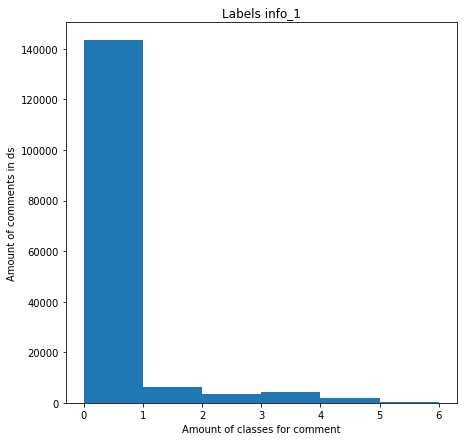

In [9]:
bins = train[classes_].sum(axis=1).unique()
bins.sort()
fig = plt.figure(figsize=(7, 7))
plt.hist(train[classes_].sum(axis=1), bins)
plt.title('Labels info_1')
plt.xlabel('Amount of classes for comment')
plt.ylabel('Amount of comments in ds')

In [10]:
train[classes_].sum(axis=0)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [11]:
for i in classes_:
    print('CLASS', i.upper())
    tmp = np.asarray(train[train[i] == 1].comment_text)
    print(tmp[-1])
    print()

CLASS TOXIC
and i'm going to keep posting the stuff u deleted until this fucking site closes down have fun u stupid ass bitch don't ever delete anything fuckin hore like i said before go to hell

CLASS SEVERE_TOXIC
Shalom 

Semite, get the fuck out of here. I will kill you, you son of a bitch if you don't leave wikipedia. If you tell anyone I said this to you, I will rape your jew family. Choke on a bagel, you faggoty hymie cock sucker. You better fucking die, before I hunt you down and piss on your face. If you get me blocked for this, I will find you and shoot you, I just want your jew fucking self gone, you dumb motherfucking piece of shit g-d damn jew. Die! Shalom. We Came In?

CLASS OBSCENE
and i'm going to keep posting the stuff u deleted until this fucking site closes down have fun u stupid ass bitch don't ever delete anything fuckin hore like i said before go to hell

CLASS THREAT
Shalom 

Semite, get the fuck out of here. I will kill you, you son of a bitch if you don't leave 

In [45]:
train, train_labels = train.drop(classes_, axis=1), train[classes_]
test, test_labels = test.drop(classes_, axis=1), test[classes_]

## Feature Engineering:

In [13]:
neg_words = [i[:-1] for i in open('negative-words.txt')]

In [16]:
symbs = ['!', '@', '#', '$', '%', '^', '&', '(', '*', '№', '=', '-', '+', '<', '>']
punct = ['.', ',', '\'', ';', ':']
smailes = [':)', ':D', ')']
neg_phrases = ['fuck you', 'screw you', 'kill you', 'beat you', 'die you', 'damn it', 'damn you', 'bitchin out', 'duck face'  ]
short_phrases = ['wtf', 'dgaf', 'fml', 'foad', 'ftw', 'milf']
races_and_orients = ['lesbian', 'gay', 'homo', 'bromance', 'dyke', 'lesbo', 'lezzie', 'faggot', 'nigga', 'nigger', 'jew', 'yankee', 'racist']

### Train features

In [14]:
neg_words_counts = train_data.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in neg_words]))

In [17]:
symbols_count = train.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in symbs]))

punct_count = train.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in punct]))

smailes_count = train.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in smailes]))

len_of_comment = train.comment_text.apply(lambda a: len(a))

capital_letters = train.comment_text.apply(lambda a: len([i for i in a if i.isupper()]))

neg_phrases_count = train.comment_text.apply(lambda a: len([i for i in neg_phrases if i in a]))

short_phrases_count = train.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in short_phrases]))

races_and_orients_count = train.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in races_and_orients]))

count_spaces = train.comment_text.apply(lambda a: len([i for i in a if i == ' ']))

count_ips = train.comment_text.apply(lambda a: len(re.findall("\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3}", a)))

In [18]:
train = train.assign(capital_letters=capital_letters,
                     len_of_comment=len_of_comment,
                     count_ips=count_ips,
                     count_spaces=count_spaces,
                     sybs = symbols_count,
                     smailes = smailes_count,
                     neg_words=neg_words_counts,
                    neg_phrases=neg_phrases_count,
                    short_phrases=short_phrases_count,
                    races_and_orients=races_and_orients_count)

### Test features

In [ ]:
neg_words_counts_ts = test.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in neg_words]))

In [ ]:
capital_letters_ts = test.comment_text.apply(lambda a: len([i for i in a if i.isupper()]))
len_of_comment_ts = test.comment_text.apply(lambda a: len(a))
count_spaces_ts = test.comment_text.apply(lambda a: len([i for i in a if i == ' ']))
count_ips_ts = test.comment_text.apply(lambda a: len(re.findall("\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3}", a)))
punct_count_ts = test.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in punct]))
symbols_count_ts = test.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in symbs]))
smailes_count_ts = test.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in smailes]))
neg_phrases_count_ts = test.comment_text.apply(lambda a: len([i for i in neg_phrases if i in a]))
short_phrases_count_ts = test.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in short_phrases]))
races_and_orients_count_ts = test.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in races_and_orients]))

In [ ]:
test = test.assign(capital_letters=capital_letters_ts,
                     len_of_comment=len_of_comment_ts,
                     count_ips=count_ips_ts,
                     count_spaces=count_spaces_ts,
                     sybs = symbols_count_ts,
                     smailes = smailes_count_ts,
                     neg_words=neg_words_counts_ts,
                    neg_phrases=neg_phrases_count_ts,
                    short_phrases=short_phrases_count_ts,
                    races_and_orients=races_and_orients_count_ts)

In [19]:
features = ['capital_letters', 'len_of_comment', 'count_ips', 'count_spaces', 'symbs', 'smailes', 'neg_words', 'neg_phrases', 'short_phrases', 'races_and_orients']

## Comments cleaning:

In [20]:
tt = TweetTokenizer(strip_handles=True, reduce_len=True)

In [21]:
def beautify_text(s):
    s = s.replace(':)', 'smile')
    s = s.replace(':D', 'laugh')
    # Removes all characters from string except letters and digits and convert letters to lowercase
    s = re.sub("[^a-zA-Z0-9]", " ", s.lower())
    # Remove new lines
    s = re.sub("\\n","", s)
    # Change urls
    s = re.sub("[a-zA-Z0-9]*(https://)[a-zA-Z0-9.]*", "url", s)
    # Remove IPs
    s = re.sub("\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3}","", s)
    # Remove usernames
    s = re.sub("\[\[.*\]","", s)
    # Remove numbers
    s = re.sub("\\b[0-9]+\\b", "", s)
    # better use (\w+[0-9])
    # fix grammar
    s = re.sub('\\bf{1,}[a-z]*(ck)\\b', 'fuck', s)
    # find cock symb lol
    s = re.sub('8={1,}D?', 'cock', s)

    #formalize text
    s = s.replace("don\'t", "do not")
    s = s.replace("doesn\'t", "does not")
    s = s.replace("didn\'t", "did not")
    s = s.replace("won\'t", "will not")
    s = s.replace("haven\'t", "have not")
    s = s.replace('haven\\\'t', 'have not')
    #s = s.replace('\'ll', ' will')
    #clean text
    s = s.replace('\\', ' ')
    s = s.replace('\n', '')
    s = s.replace("'s", ' is')
    s = s.replace('“', '')
    s = s.replace('fck', 'fuck')
    s = s.replace('wtf', 'what the fuck')
    s = s.replace('cockwad', 'idiot')
    s = s.replace('скоморохъ', 'buffoon')
    s = s.replace('backash', 'backlash')
    s = s.replace('bizarrethere', 'bizarre there')
    s = s.replace('backash', 'backlash')
    s = s.replace('dummasses', 'dumbass')
    s = s.replace('lesbianswomen', 'lesbian women')
    s = s.replace('bisexualis', 'bisexual')
    s = s.replace('sexualitypenis','sexuality penis')
    s = s.replace('dorkgasm', 'orgasm')
    s = s.replace('cockmy', 'cock my')
    s = s.replace('supertroll', 'super troll')
    s = s.replace('faggotttttttt', 'faggot')
    s = s.replace('sucks50', 'sucks 50')
    s = s.replace('themfuck', 'them fuck')
    s = s.replace('offenderfugitive', 'offender fugitive')
    s = s.replace('creationisrael', 'creation israel')
    s = s.replace('assholestating', 'asshole stating')
    s = s.replace('idiotenough', 'idiot enough')
    s = s.replace('lessblunt', 'less blunt')
    s = s.replace('anticanadian', 'anti canadian')
    s = s.replace('afrikanblack', 'african black')
    s = s.replace('againbitch', 'again bitch')
    s = s.replace('animalfucker', 'animal fucker')
    return s

In [ ]:
beautiful_text_tr = train.comment_text.apply(beautify_text)
beautiful_text_ts = test.comment_text.apply(beautify_text)

words_tr = [tt.tokenize(i) for i in beautiful_text_tr]
words_ts = [tt.tokenize(i) for i in beautiful_text_ts]

words_tr = [[i for i in j if i not in stopwords.words('english')] for j in words_tr]
words_ts = [[i for i in j if i not in stopwords.words('english')] for j in words_ts]

np.save('train_preproc', words_tr)
np.save('test_preproc', words_ts)

In [ ]:
words_tr = np.load('train_preproc.npy')
words_ts = np.load('test_preproc.npy')

In [ ]:
text_train_new = [' '.join(i) for i in words_tr]
text_test_new = [' '.join(i) for i in words_ts]

## Encoding:

In [23]:
tfv = TfidfVectorizer(min_df=50,  max_features=3000, 
            analyzer='char',ngram_range=(1,3))

In [ ]:
train = tfv.fit_transform(text_train_new)
test = tfv.transform(text_test_new)

## XGBoost Classification

### Fitting for each label:

In [39]:
xgb_params = {
    'max_depth': [2, 5, 10, 100],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'n_estimators': [10, 100, 500, 1000]
}
cv = GridSearchCV(XGBClassifier(), xgb_params, scoring=log_loss, cv=3)

In [32]:
for i in classes_:
    cv.fit(train, train_labels[i])
    print(cv.best_estimator_)

### Classifier Chain:

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(train, train_labels, test_size=.2,
                                                    random_state=42)

chains = [ClassifierChain(XGBClassifier(), order='random', random_state=i)
          for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

y_pred_chains = np.array([chain.predict(X_eval) for chain in
                          chains])
y_pred_ensemble = y_pred_chains.mean(axis=0)

chain_jaccard_scores = [jaccard_similarity_score(y_test, y_pred_chain >= .5)
                        for y_pred_chain in y_pred_chains]
logloss_scores = [log_loss(y_eval, y_pred_chain >= .5)
                        for y_pred_chain in y_pred_chains]
